<a href="https://colab.research.google.com/github/alipk26/Proyek-Kedua-Membuat-Model-Machine-Learning-dengan-Data-Time-Series/blob/main/Proyek_Kedua_Membuat_Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional,Dropout
import matplotlib.pyplot as plt

#mengelola dataset

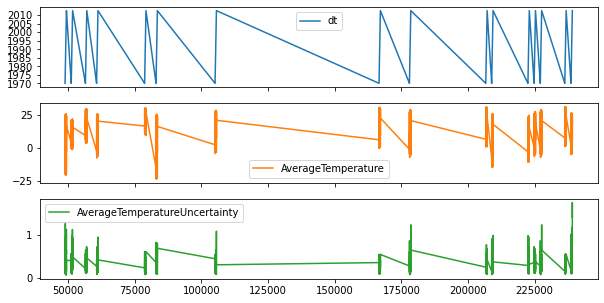

In [ ]:
df = pd.read_csv('/content/GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv', encoding= 'unicode_escape')
df.drop(['City','Latitude','Longitude'], axis=1, inplace=True)

df['dt'] = pd.to_datetime(df['dt'])  
get_data = (df['dt'] > '1970-01-01') & (df['dt'] <= '2012-09-01') #data yang diambil tahun 1970 - 2012
df = df.loc[get_data]

df = df.loc[df['Country'].isin(['China'])]  #mengambil data negara China
df.drop(['Country'], axis=1, inplace=True)
df.reset_index(drop=True)
df.dropna(subset=['AverageTemperature'],inplace=True) #menghilankan baris yang tidak mempunyai nilai
df.dropna(subset=['AverageTemperatureUncertainty'],inplace=True)
df_plot = df
df_plot[df_plot.columns.to_list()].plot(subplots=True, figsize=(10, 5))
plt.show()


#plot data

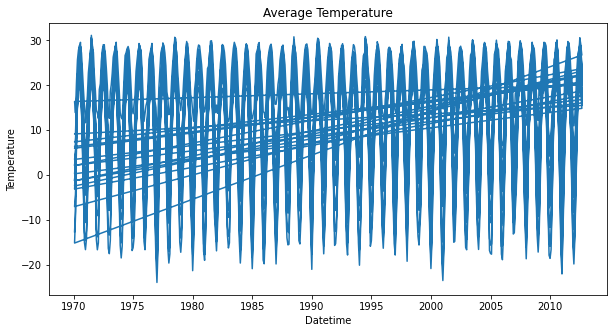

In [ ]:
dates = df['dt'].values
temp = df['AverageTemperature'].values

dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(10,5))
plt.plot(dates, temp)

plt.title('Average Temperature')
plt.ylabel('Temperature')
plt.xlabel('Datetime')

df.dtypes
x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size = 0.2, shuffle = False )

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)


#model sequential.

In [ ]:
tf.keras.backend.set_floatx('float64')
train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
val_set = windowed_dataset(x_valid, window_size=64, batch_size=200, shuffle_buffer=1000)
model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])


#fungsi callback

In [ ]:
Mae = (df['AverageTemperature'].max() - df['AverageTemperature'].min()) * 10/100
print(Mae)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.4 and logs.get('val_mae')<2.4):
      print("\nMAE < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()


5.505800000000001


#fungsi fit()

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data = val_set, 
          callbacks=[callbacks])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


      6/Unknown - 21s 153ms/step - loss: 12.9962 - mae: 13.4916

33/33 [==============================] - 28s 226ms/step - loss: 13.6557 - mae: 14.1492 - val_loss: 13.4429 - val_mae: 13.9369
Epoch 2/100
33/33 [==============================] - 6s 177ms/step - loss: 13.2099 - mae: 13.7032 - val_loss: 12.9470 - val_mae: 13.4411
Epoch 3/100
33/33 [==============================] - 6s 166ms/step - loss: 12.7646 - mae: 13.2582 - val_loss: 12.4010 - val_mae: 12.8961
Epoch 4/100
33/33 [==============================] - 6s 180ms/step - loss: 12.2488 - mae: 12.7418 - val_loss: 11.7475 - val_mae: 12.2411
Epoch 5/100
33/33 [==============================] - 6s 168ms/step - loss: 11.6375 - mae: 12.1308 - val_loss: 10.9813 - val_mae: 11.4704
Epoch 6/100
33/33 [==============================] - 6s 164ms/step - loss: 10.9351 - mae: 11.4275 - val_loss: 10.1575 - val_mae: 10.6440
Epoch 7/100
33/33 [==============================] - 6s 165ms/step - loss: 10.1737 - mae: 10.6644 - val_loss: 9.3623 - val_mae: 9.8536
Epoch 8/100
33/33 [==============================] - 6

#loss model

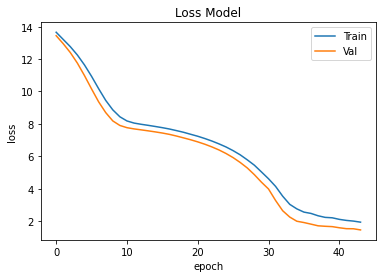

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

#akurasi model

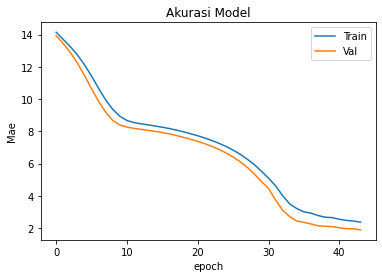

In [ ]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()